1 : Installation et imports

In [2]:
# Installation des packages nécessaires (si besoin)
# !pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Configuration pour utiliser le GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU configuré: {len(gpus)} GPU(s) disponible(s)")
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.20.0
GPU disponible: []


2 : Chargement des données

In [5]:
# Définir le chemin vers vos fichiers CSV
data_path = "./ddos_csv_files/"

# Charger tous les fichiers training
print("🔄 Chargement des fichiers training...")
training_files = glob.glob(f'{data_path}*-training.csv')
print(f"Fichiers training trouvés: {len(training_files)}")

dfs_train = []
for file in training_files:
    print(f"  - {file}")
    df = pd.read_csv(file)
    dfs_train.append(df)

df_train_orig = pd.concat(dfs_train, ignore_index=True)

# Charger tous les fichiers testing
print("\n🔄 Chargement des fichiers testing...")
testing_files = glob.glob(f'{data_path}*-testing.csv')
print(f"Fichiers testing trouvés: {len(testing_files)}")

dfs_test = []
for file in testing_files:
    print(f"  - {file}")
    df = pd.read_csv(file)
    dfs_test.append(df)

df_test_orig = pd.concat(dfs_test, ignore_index=True)

print(f"\n📊 Données originales chargées:")
print(f"   Train original: {df_train_orig.shape}")
print(f"   Test original: {df_test_orig.shape}")

# FUSION ET RE-SPLIT PROPRE
print("\n🔀 Fusion et re-split des données (80/20)...")
df_all = pd.concat([df_train_orig, df_test_orig], ignore_index=True)
print(f"   Total: {df_all.shape}")

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_all,
    test_size=0.2,
    random_state=42,
    stratify=df_all['Label']
)

print(f"\n✅ Après re-split stratifié:")
print(f"   Train: {df_train.shape} ({len(df_train)/len(df_all)*100:.1f}%)")
print(f"   Test: {df_test.shape} ({len(df_test)/len(df_all)*100:.1f}%)")

# Vérifier la distribution
print(f"\n📊 Distribution Train:")
print(df_train['Label'].value_counts(normalize=True).mul(100).round(2))
print(f"\n📊 Distribution Test:")
print(df_test['Label'].value_counts(normalize=True).mul(100).round(2))

🔄 Chargement des fichiers training...
Fichiers training trouvés: 7
  - ./ddos_csv_files\LDAP-training.csv
  - ./ddos_csv_files\MSSQL-training.csv
  - ./ddos_csv_files\NetBIOS-training.csv
  - ./ddos_csv_files\Portmap-training.csv
  - ./ddos_csv_files\Syn-training.csv
  - ./ddos_csv_files\UDP-training.csv
  - ./ddos_csv_files\UDPLag-training.csv

🔄 Chargement des fichiers testing...
Fichiers testing trouvés: 10
  - ./ddos_csv_files\DNS-testing.csv
  - ./ddos_csv_files\LDAP-testing.csv
  - ./ddos_csv_files\MSSQL-testing.csv
  - ./ddos_csv_files\NetBIOS-testing.csv
  - ./ddos_csv_files\NTP-testing.csv
  - ./ddos_csv_files\SNMP-testing.csv
  - ./ddos_csv_files\Syn-testing.csv
  - ./ddos_csv_files\TFTP-testing.csv
  - ./ddos_csv_files\UDP-testing.csv
  - ./ddos_csv_files\UDPLag-testing.csv

📊 Données originales chargées:
   Train original: (125170, 78)
   Test original: (306201, 78)

🔀 Fusion et re-split des données (80/20)...
   Total: (431371, 78)

✅ Après re-split stratifié:
   Train: (3

3 : Exploration des données

In [6]:
# Aperçu du dataset
print("📊 Aperçu des données d'entraînement:")
print(df_train.head())

print("\n📋 Informations sur les colonnes:")
print(df_train.info())

print("\n📈 Distribution des labels:")
print(df_train['Label'].value_counts())

print("\n📉 Statistiques descriptives:")
print(df_train.describe())

# Vérifier les valeurs manquantes
print("\n❓ Valeurs manquantes:")
missing = df_train.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("Aucune valeur manquante ✅")

📊 Aperçu des données d'entraînement:
        Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
162964        17            306                  8                       0   
218971        17           1001                 30                       0   
358390        17        2998020                  4                       0   
210410        17            296                 40                       0   
237909        17            625                 18                       0   

        Fwd Packets Length Total  Bwd Packets Length Total  \
162964                    3520.0                       0.0   
218971                   13200.0                       0.0   
358390                    2064.0                       0.0   
210410                   17600.0                       0.0   
237909                    7344.0                       0.0   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
162964                  440.0            

4 : Visualisation de la distribution des classes

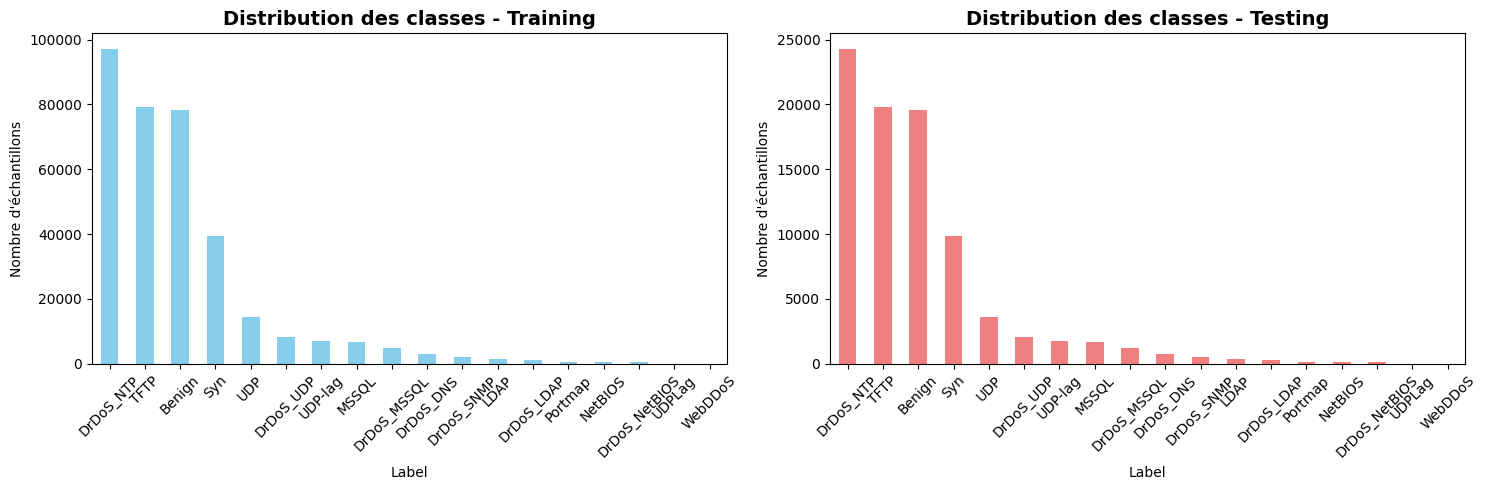


📊 Répartition en pourcentages (Train):
Label
DrDoS_NTP        28.135359
TFTP             22.930721
Benign           22.679197
Syn              11.445511
UDP               4.193616
DrDoS_UDP         2.415560
UDP-lag           2.056819
MSSQL             1.975682
DrDoS_MSSQL       1.440179
DrDoS_DNS         0.850488
DrDoS_SNMP        0.629970
LDAP              0.441906
DrDoS_LDAP        0.333820
Portmap           0.158796
NetBIOS           0.149234
DrDoS_NetBIOS     0.138512
UDPLag            0.012750
WebDDoS           0.011881
Name: proportion, dtype: float64


In [7]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution train
df_train['Label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution des classes - Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Nombre d\'échantillons')
axes[0].tick_params(axis='x', rotation=45)

# Distribution test
df_test['Label'].value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution des classes - Testing', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Nombre d\'échantillons')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Pourcentages
print("\n📊 Répartition en pourcentages (Train):")
print(df_train['Label'].value_counts(normalize=True) * 100)

5 : Nettoyage des données

In [8]:
print("🧹 Nettoyage des données...")

# Fonction de nettoyage
def clean_dataframe(df):
    df_clean = df.copy()

    # Remplacer les valeurs infinies par NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Nombre de NaN avant nettoyage
    nan_before = df_clean.isnull().sum().sum()
    print(f"   NaN avant: {nan_before}")

    # Remplir les NaN par la médiane de chaque colonne
    for col in df_clean.columns:
        if df_clean[col].dtype in ['float64', 'int64'] and col != 'Label':
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    # Nombre de NaN après nettoyage
    nan_after = df_clean.isnull().sum().sum()
    print(f"   NaN après: {nan_after}")

    return df_clean

# Nettoyer train et test
df_train_clean = clean_dataframe(df_train)
df_test_clean = clean_dataframe(df_test)

print(f"\n✅ Nettoyage terminé:")
print(f"   Train: {df_train_clean.shape}")
print(f"   Test: {df_test_clean.shape}")

🧹 Nettoyage des données...
   NaN avant: 0
   NaN après: 0
   NaN avant: 0
   NaN après: 0

✅ Nettoyage terminé:
   Train: (345096, 78)
   Test: (86275, 78)


In [11]:
print("🔄 Nettoyage et uniformisation des labels...")

# Fonction de nettoyage des labels
def clean_labels(label):
    """Nettoyer et uniformiser les labels"""
    # Mettre en minuscules pour comparer
    label_clean = str(label).strip()

    # Regrouper UDPLag et UDP-lag
    if label_clean in ['UDP-lag', 'UDPLag']:
        return 'UDPLag'

    # Autres labels : garder tel quel
    return label_clean

# Appliquer le nettoyage
df_train_clean['Label'] = df_train_clean['Label'].apply(clean_labels)
df_test_clean['Label'] = df_test_clean['Label'].apply(clean_labels)

# Vérifier les labels uniques après nettoyage
print("\n📋 Labels après nettoyage:")
all_labels_clean = pd.concat([df_train_clean['Label'], df_test_clean['Label']]).unique()
print(f"   Nombre de labels uniques: {len(all_labels_clean)}")
print(f"   Labels: {sorted(all_labels_clean)}")

# Distribution après nettoyage
print("\n📊 Distribution Train après nettoyage:")
print(df_train_clean['Label'].value_counts().sort_index())

🔄 Nettoyage et uniformisation des labels...

📋 Labels après nettoyage:
   Nombre de labels uniques: 17
   Labels: ['Benign', 'DrDoS_DNS', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_UDP', 'LDAP', 'MSSQL', 'NetBIOS', 'Portmap', 'Syn', 'TFTP', 'UDP', 'UDPLag', 'WebDDoS']

📊 Distribution Train après nettoyage:
Label
Benign           78265
DrDoS_DNS         2935
DrDoS_LDAP        1152
DrDoS_MSSQL       4970
DrDoS_NTP        97094
DrDoS_NetBIOS      478
DrDoS_SNMP        2174
DrDoS_UDP         8336
LDAP              1525
MSSQL             6818
NetBIOS            515
Portmap            548
Syn              39498
TFTP             79133
UDP              14472
UDPLag            7142
WebDDoS             41
Name: count, dtype: int64


In [12]:
# Après le nettoyage des labels, AVANT l'encodage
print("🔍 Filtrage des classes trop petites...")

# Compter les échantillons par classe
label_counts = df_train_clean['Label'].value_counts()
print(f"\nDistribution complète:")
print(label_counts)

# Définir un seuil minimum
MIN_SAMPLES = 500

# Identifier les classes à garder
classes_to_keep = label_counts[label_counts >= MIN_SAMPLES].index.tolist()
print(f"\n✅ Classes gardées (>= {MIN_SAMPLES} échantillons): {len(classes_to_keep)}")
print(classes_to_keep)

# Classes retirées
classes_removed = label_counts[label_counts < MIN_SAMPLES].index.tolist()
if classes_removed:
    print(f"\n❌ Classes retirées (< {MIN_SAMPLES} échantillons): {len(classes_removed)}")
    for cls in classes_removed:
        print(f"   - {cls}: {label_counts[cls]} échantillons")

# Filtrer les dataframes
df_train_filtered = df_train_clean[df_train_clean['Label'].isin(classes_to_keep)]
df_test_filtered = df_test_clean[df_test_clean['Label'].isin(classes_to_keep)]

print(f"\n📊 Résultat:")
print(f"   Train: {len(df_train_clean)} → {len(df_train_filtered)} ({len(df_train_filtered)/len(df_train_clean)*100:.1f}%)")
print(f"   Test: {len(df_test_clean)} → {len(df_test_filtered)} ({len(df_test_filtered)/len(df_test_clean)*100:.1f}%)")
print(f"   Classes finales: {len(df_train_filtered['Label'].unique())}")

# Remplacer pour la suite
df_train_clean = df_train_filtered
df_test_clean = df_test_filtered

🔍 Filtrage des classes trop petites...

Distribution complète:
Label
DrDoS_NTP        97094
TFTP             79133
Benign           78265
Syn              39498
UDP              14472
DrDoS_UDP         8336
UDPLag            7142
MSSQL             6818
DrDoS_MSSQL       4970
DrDoS_DNS         2935
DrDoS_SNMP        2174
LDAP              1525
DrDoS_LDAP        1152
Portmap            548
NetBIOS            515
DrDoS_NetBIOS      478
WebDDoS             41
Name: count, dtype: int64

✅ Classes gardées (>= 500 échantillons): 15
['DrDoS_NTP', 'TFTP', 'Benign', 'Syn', 'UDP', 'DrDoS_UDP', 'UDPLag', 'MSSQL', 'DrDoS_MSSQL', 'DrDoS_DNS', 'DrDoS_SNMP', 'LDAP', 'DrDoS_LDAP', 'Portmap', 'NetBIOS']

❌ Classes retirées (< 500 échantillons): 2
   - DrDoS_NetBIOS: 478 échantillons
   - WebDDoS: 41 échantillons

📊 Résultat:
   Train: 345096 → 344577 (99.8%)
   Test: 86275 → 86145 (99.8%)
   Classes finales: 15


In [24]:
print("🔄 FUSION DES CLASSES SIMILAIRES (basée sur l'analyse)")
print("=" * 70)

# Fonction de fusion intelligente
def merge_attack_classes(label):
    """
    Fusion des classes qui se confondent mutuellement
    Basé sur l'analyse de la matrice de confusion
    """
    label_str = str(label).strip()

    # Groupe 1: TOUS LES UDP (sauf UDPLag) → UDP_Attack
    # UDP et DrDoS_UDP se confondent à 95.6%
    if 'UDP' in label_str.upper():
        if 'LAG' in label_str.upper():
            return 'UDPLag'  # Garder UDPLag séparé (performance acceptable)
        return 'UDP_Attack'  # Fusionner UDP + DrDoS_UDP

    # Groupe 2: TOUS LES MSSQL → MSSQL_Attack
    # MSSQL et DrDoS_MSSQL se confondent mutuellement (51.8% et 33.5%)
    if 'MSSQL' in label_str.upper():
        return 'MSSQL_Attack'

    # Groupe 3: LDAP + SNMP → Directory_Protocol_Attack
    # Triangle de confusion entre LDAP, DrDoS_LDAP, DrDoS_SNMP
    if 'LDAP' in label_str.upper() or 'SNMP' in label_str.upper():
        return 'Directory_Protocol_Attack'

    # Groupe 4: NetBIOS + Portmap → Port_Service_Attack
    # NetBIOS et Portmap se confondent mutuellement (30.4% et 34.4%)
    if 'NETBIOS' in label_str.upper() or label_str == 'Portmap':
        return 'Port_Service_Attack'

    # Groupe 5: Garder DNS séparé (malgré performances moyennes)
    # Car patterns différents des autres
    if 'DNS' in label_str.upper():
        return 'DNS_Attack'

    # Tous les autres restent inchangés
    return label_str

# Sauvegarder les labels originaux pour comparaison
df_train_clean['Label_Original'] = df_train_clean['Label'].copy()
df_test_clean['Label_Original'] = df_test_clean['Label'].copy()

# Appliquer la fusion
df_train_clean['Label'] = df_train_clean['Label'].apply(merge_attack_classes)
df_test_clean['Label'] = df_test_clean['Label'].apply(merge_attack_classes)

# Afficher le mapping
print("\n📋 MAPPING DES FUSIONS:")
print("-" * 70)

# Créer un mapping pour affichage
original_to_merged = {}
all_originals = pd.concat([
    df_train_clean['Label_Original'],
    df_test_clean['Label_Original']
]).unique()

for orig in sorted(all_originals):
    merged = merge_attack_classes(orig)
    if merged not in original_to_merged:
        original_to_merged[merged] = []
    original_to_merged[merged].append(orig)

for merged, originals in sorted(original_to_merged.items()):
    if len(originals) > 1:
        print(f"✅ {merged:30s} ← {', '.join(originals)}")
    else:
        print(f"   {merged:30s} (inchangé)")

# Statistiques avant/après
print("\n" + "=" * 70)
print("📊 STATISTIQUES:")
print("-" * 70)

n_classes_before = len(pd.concat([
    df_train_clean['Label_Original'],
    df_test_clean['Label_Original']
]).unique())

n_classes_after = len(pd.concat([
    df_train_clean['Label'],
    df_test_clean['Label']
]).unique())

print(f"Nombre de classes AVANT fusion: {n_classes_before}")
print(f"Nombre de classes APRÈS fusion: {n_classes_after}")
print(f"Réduction: {n_classes_before - n_classes_after} classes")

# Distribution détaillée après fusion
print("\n📊 DISTRIBUTION APRÈS FUSION:")
print("-" * 70)
print("\nTrain set:")
train_dist = df_train_clean['Label'].value_counts().sort_index()
for label, count in train_dist.items():
    pct = count / len(df_train_clean) * 100
    print(f"   {label:30s}: {count:7,d} ({pct:5.2f}%)")

print(f"\n   TOTAL: {len(df_train_clean):,}")

print("\nTest set:")
test_dist = df_test_clean['Label'].value_counts().sort_index()
for label, count in test_dist.items():
    pct = count / len(df_test_clean) * 100
    print(f"   {label:30s}: {count:7,d} ({pct:5.2f}%)")

print(f"\n   TOTAL: {len(df_test_clean):,}")

print("\n" + "=" * 70)
print("✅ Fusion terminée ! Passez à l'encodage (Cellule 6)")
print("=" * 70)

# Supprimer la colonne temporaire pour ne pas perturber la suite
df_train_clean = df_train_clean.drop('Label_Original', axis=1)
df_test_clean = df_test_clean.drop('Label_Original', axis=1)

🔄 FUSION DES CLASSES SIMILAIRES (basée sur l'analyse)

📋 MAPPING DES FUSIONS:
----------------------------------------------------------------------
   Benign                         (inchangé)
   DNS_Attack                     (inchangé)
✅ Directory_Protocol_Attack      ← DrDoS_LDAP, DrDoS_SNMP, LDAP
   DrDoS_NTP                      (inchangé)
✅ MSSQL_Attack                   ← DrDoS_MSSQL, MSSQL
✅ Port_Service_Attack            ← NetBIOS, Portmap
   Syn                            (inchangé)
   TFTP                           (inchangé)
   UDPLag                         (inchangé)
✅ UDP_Attack                     ← DrDoS_UDP, UDP

📊 STATISTIQUES:
----------------------------------------------------------------------
Nombre de classes AVANT fusion: 15
Nombre de classes APRÈS fusion: 10
Réduction: 5 classes

📊 DISTRIBUTION APRÈS FUSION:
----------------------------------------------------------------------

Train set:
   Benign                        :  78,265 (22.71%)
   DNS_Attack    

6 : Encodage des labels multi-classe

In [25]:
print("🏷️ Encodage des labels en MULTI-CLASSE (après fusion)...")

from sklearn.preprocessing import LabelEncoder

# Créer l'encodeur
label_encoder = LabelEncoder()

# Fit sur tous les labels possibles (train + test)
all_labels = pd.concat([df_train_clean['Label'], df_test_clean['Label']])
label_encoder.fit(all_labels)

# Encoder train
df_train_encoded = df_train_clean.copy()
df_train_encoded['Label'] = label_encoder.transform(df_train_clean['Label'])

# Encoder test
df_test_encoded = df_test_clean.copy()
df_test_encoded['Label'] = label_encoder.transform(df_test_clean['Label'])

# Afficher le mapping
print("\n📋 Mapping des labels (Type d'attaque → Numéro):")
print("=" * 70)
for idx, label_name in enumerate(label_encoder.classes_):
    count_train = (df_train_encoded['Label'] == idx).sum()
    count_test = (df_test_encoded['Label'] == idx).sum()
    print(f"   {idx:2d}: {label_name:30s} | Train: {count_train:7,d} | Test: {count_test:7,d}")

print("=" * 70)
print(f"\n✅ Nombre de classes après fusion: {len(label_encoder.classes_)}")
print(f"   (au lieu de 18 avant fusion)")

# Sauvegarder l'encodeur pour plus tard
import joblib
joblib.dump(label_encoder, 'label_encoder_merged.pkl')
print("\n✅ Label encoder sauvegardé dans 'label_encoder_merged.pkl'")

🏷️ Encodage des labels en MULTI-CLASSE (après fusion)...

📋 Mapping des labels (Type d'attaque → Numéro):
    0: Benign                         | Train:  78,265 | Test:  19,566
    1: DNS_Attack                     | Train:   2,935 | Test:     734
    2: Directory_Protocol_Attack      | Train:   4,851 | Test:   1,212
    3: DrDoS_NTP                      | Train:  97,094 | Test:  24,274
    4: MSSQL_Attack                   | Train:  11,788 | Test:   2,947
    5: Port_Service_Attack            | Train:   1,063 | Test:     266
    6: Syn                            | Train:  39,498 | Test:   9,875
    7: TFTP                           | Train:  79,133 | Test:  19,784
    8: UDPLag                         | Train:   7,142 | Test:   1,785
    9: UDP_Attack                     | Train:  22,808 | Test:   5,702

✅ Nombre de classes après fusion: 10
   (au lieu de 18 avant fusion)

✅ Label encoder sauvegardé dans 'label_encoder_merged.pkl'


7 : Séparation features/labels et normalisation

In [26]:
print("🔢 Séparation des features et labels...")

# Séparer X (features) et y (labels)
X_train = df_train_encoded.drop('Label', axis=1)
y_train = df_train_encoded['Label'].values

X_test = df_test_encoded.drop('Label', axis=1)
y_test = df_test_encoded['Label'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Normalisation (StandardScaler)
print("\n📏 Normalisation des données...")
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalisation terminée")
print(f"   Mean après normalisation: {X_train_scaled.mean():.6f}")
print(f"   Std après normalisation: {X_train_scaled.std():.6f}")

🔢 Séparation des features et labels...
X_train shape: (344577, 77)
y_train shape: (344577,)
X_test shape: (86145, 77)
y_test shape: (86145,)

📏 Normalisation des données...
✅ Normalisation terminée
   Mean après normalisation: -0.000000
   Std après normalisation: 0.918780


 8 : Création des séquences temporelles

In [27]:
print("📦 Création des séquences temporelles pour LSTM...")

# Paramètres
SEQUENCE_LENGTH = 10  # Nombre de flux consécutifs dans une séquence
STEP = 5  # Pas de la fenêtre glissante (overlap)

def create_sequences(X, y, seq_length, step):
    """
    Crée des séquences temporelles avec fenêtre glissante
    """
    X_seq = []
    y_seq = []

    for i in range(0, len(X) - seq_length, step):
        X_seq.append(X[i:i+seq_length])
        # Label = label majoritaire dans la séquence (ou dernier)
        y_seq.append(y[i+seq_length-1])  # Prendre le dernier label

    return np.array(X_seq), np.array(y_seq)

# Créer les séquences
print(f"Création des séquences (length={SEQUENCE_LENGTH}, step={STEP})...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH, STEP)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH, STEP)

print(f"\n✅ Séquences créées:")
print(f"   X_train_seq shape: {X_train_seq.shape}  # (samples, timesteps, features)")
print(f"   y_train_seq shape: {y_train_seq.shape}")
print(f"   X_test_seq shape: {X_test_seq.shape}")
print(f"   y_test_seq shape: {y_test_seq.shape}")

# Distribution après séquençage
print(f"\n📊 Distribution des labels dans les séquences (Train):")
unique, counts = np.unique(y_train_seq, return_counts=True)
for label, count in zip(unique, counts):
    label_name = "BENIGN" if label == 0 else "ATTACK"
    print(f"   {label_name} ({label}): {count} ({count/len(y_train_seq)*100:.2f}%)")

📦 Création des séquences temporelles pour LSTM...
Création des séquences (length=10, step=5)...

✅ Séquences créées:
   X_train_seq shape: (68914, 10, 77)  # (samples, timesteps, features)
   y_train_seq shape: (68914,)
   X_test_seq shape: (17227, 10, 77)
   y_test_seq shape: (17227,)

📊 Distribution des labels dans les séquences (Train):
   BENIGN (0): 15649 (22.71%)
   ATTACK (1): 587 (0.85%)
   ATTACK (2): 996 (1.45%)
   ATTACK (3): 19424 (28.19%)
   ATTACK (4): 2317 (3.36%)
   ATTACK (5): 221 (0.32%)
   ATTACK (6): 7908 (11.48%)
   ATTACK (7): 15830 (22.97%)
   ATTACK (8): 1383 (2.01%)
   ATTACK (9): 4599 (6.67%)


9 : Split validation set

In [28]:
print("🔄 Création d'un ensemble de validation...")

# Split train en train + validation (80/20)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_train_seq
)

print(f"✅ Split effectué:")
print(f"   Train final: {X_train_final.shape[0]} échantillons")
print(f"   Validation: {X_val.shape[0]} échantillons")
print(f"   Test: {X_test_seq.shape[0]} échantillons")

# Vérifier la distribution
print(f"\n📊 Distribution Train:")
unique, counts = np.unique(y_train_final, return_counts=True)
for label, count in zip(unique, counts):
    print(f"   Classe {label}: {count} ({count/len(y_train_final)*100:.2f}%)")

print(f"\n📊 Distribution Validation:")
unique, counts = np.unique(y_val, return_counts=True)
for label, count in zip(unique, counts):
    print(f"   Classe {label}: {count} ({count/len(y_val)*100:.2f}%)")

🔄 Création d'un ensemble de validation...
✅ Split effectué:
   Train final: 55131 échantillons
   Validation: 13783 échantillons
   Test: 17227 échantillons

📊 Distribution Train:
   Classe 0: 12519 (22.71%)
   Classe 1: 470 (0.85%)
   Classe 2: 797 (1.45%)
   Classe 3: 15539 (28.19%)
   Classe 4: 1854 (3.36%)
   Classe 5: 177 (0.32%)
   Classe 6: 6326 (11.47%)
   Classe 7: 12664 (22.97%)
   Classe 8: 1106 (2.01%)
   Classe 9: 3679 (6.67%)

📊 Distribution Validation:
   Classe 0: 3130 (22.71%)
   Classe 1: 117 (0.85%)
   Classe 2: 199 (1.44%)
   Classe 3: 3885 (28.19%)
   Classe 4: 463 (3.36%)
   Classe 5: 44 (0.32%)
   Classe 6: 1582 (11.48%)
   Classe 7: 3166 (22.97%)
   Classe 8: 277 (2.01%)
   Classe 9: 920 (6.67%)


10 : Construction du modèle LSTM

In [29]:
print("🧠 Construction du modèle LSTM pour classification MULTI-CLASSE...")

# Paramètres du modèle
n_timesteps = X_train_final.shape[1]  # 10
n_features = X_train_final.shape[2]   # nombre de features
n_classes = len(label_encoder.classes_)  # ← NOMBRE DE CLASSES

print(f"   Timesteps: {n_timesteps}")
print(f"   Features: {n_features}")
print(f"   Classes: {n_classes}")
print(f"   Types d'attaques: {list(label_encoder.classes_)}")

# Architecture du modèle
model = Sequential([
    # Première couche LSTM bidirectionnelle
    Bidirectional(LSTM(128, return_sequences=True),
                  input_shape=(n_timesteps, n_features)),
    Dropout(0.3),

    # Deuxième couche LSTM
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # Couches Dense
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.2),

    # ⚠️ COUCHE DE SORTIE MULTI-CLASSE
    Dense(n_classes, activation='softmax')  # ← softmax pour multi-classe
])

# ⚠️ COMPILATION POUR MULTI-CLASSE
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # ← Loss pour multi-classe
    metrics=['accuracy']
)

# Résumé du modèle
print("\n📋 Architecture du modèle:")
model.summary()

print(f"\n✅ Modèle configuré pour {n_classes} classes")

🧠 Construction du modèle LSTM pour classification MULTI-CLASSE...
   Timesteps: 10
   Features: 77
   Classes: 10
   Types d'attaques: ['Benign', 'DNS_Attack', 'Directory_Protocol_Attack', 'DrDoS_NTP', 'MSSQL_Attack', 'Port_Service_Attack', 'Syn', 'TFTP', 'UDPLag', 'UDP_Attack']

📋 Architecture du modèle:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 10, 256)        │       210,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,690 (1.14 MB)

 Trainable params: 299,690 (1.14 MB)

 Non-trainable params: 0 (0.00 B)


✅ Modèle configuré pour 10 classes


11 : Callbacks pour l'entraînement

In [30]:
print("🎯 Configuration des callbacks...")

# Early Stopping: arrête si pas d'amélioration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: réduit le learning rate si plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# ModelCheckpoint: sauvegarde le meilleur modèle
checkpoint = ModelCheckpoint(
    'best_lstm_ddos_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("✅ Callbacks configurés:")
print("   - Early Stopping (patience=10)")
print("   - Reduce LR on Plateau (patience=5)")
print("   - Model Checkpoint")

🎯 Configuration des callbacks...
✅ Callbacks configurés:
   - Early Stopping (patience=10)
   - Reduce LR on Plateau (patience=5)
   - Model Checkpoint


12 : Entraînement du modèle

In [31]:
print("🚀 Début de l'entraînement MULTI-CLASSE...\n")

# Calculer le class weight pour gérer le déséquilibre
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("⚖️ Class weights (pour équilibrer les classes):")
for class_id, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[class_id]
    print(f"   {class_id:2d} ({class_name:15s}): {weight:.4f}")

print()

# Entraînement
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ Entraînement terminé!")

🚀 Début de l'entraînement MULTI-CLASSE...

⚖️ Class weights (pour équilibrer les classes):
    0 (Benign         ): 0.4404
    1 (DNS_Attack     ): 11.7300
    2 (Directory_Protocol_Attack): 6.9173
    3 (DrDoS_NTP      ): 0.3548
    4 (MSSQL_Attack   ): 2.9736
    5 (Port_Service_Attack): 31.1475
    6 (Syn            ): 0.8715
    7 (TFTP           ): 0.4353
    8 (UDPLag         ): 4.9847
    9 (UDP_Attack     ): 1.4985

Epoch 1/50
857/862 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4769 - loss: 1.6507
Epoch 1: val_accuracy improved from None to 0.92933, saving model to best_lstm_ddos_model.keras
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6597 - loss: 1.2278 - val_accuracy: 0.9293 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 2/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8876 - loss: 0.7161
Epoch 2: val_accuracy improved from 0.92933 to 0.94080, saving model to best_lstm_ddos_model.keras
862/862 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.898

13 : Visualisation de l'entraînement

📈 Visualisation des courbes d'apprentissage...


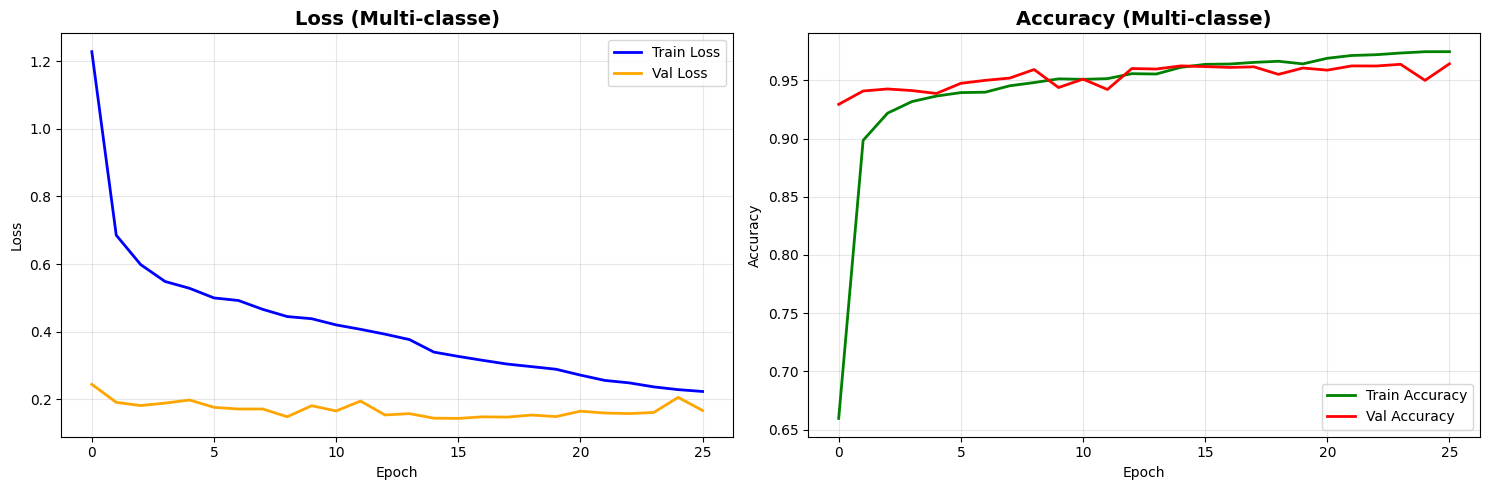


🏆 Meilleurs résultats (Epoch 26):
   Train Accuracy: 0.9746
   Val Accuracy: 0.9642
   Val Loss: 0.1670


In [32]:
print("📈 Visualisation des courbes d'apprentissage...")

# Créer les graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='orange')
axes[0].set_title('Loss (Multi-classe)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='green')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='red')
axes[1].set_title('Accuracy (Multi-classe)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher les meilleurs résultats
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n🏆 Meilleurs résultats (Epoch {best_epoch + 1}):")
print(f"   Train Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"   Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"   Val Loss: {history.history['val_loss'][best_epoch]:.4f}")

 14 : Évaluation sur le test set

In [33]:
print("🎯 Évaluation sur le test set (MULTI-CLASSE)...\n")

# Prédictions
y_pred_proba = model.predict(X_test_seq, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)  # ← Prendre la classe avec la plus haute proba

# Métriques globales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_seq, y_pred)
precision = precision_score(y_test_seq, y_pred, average='weighted')
recall = recall_score(y_test_seq, y_pred, average='weighted')
f1 = f1_score(y_test_seq, y_pred, average='weighted')

print("\n📊 Résultats GLOBAUX sur le Test Set:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (weighted): {precision:.4f}")
print(f"   Recall (weighted):    {recall:.4f}")
print(f"   F1-Score (weighted):  {f1:.4f}")

# Classification report détaillé PAR CLASSE
print("\n📋 Classification Report (par type d'attaque):")
print("=" * 80)
print(classification_report(y_test_seq, y_pred,
                          target_names=label_encoder.classes_,
                          digits=4))
print("=" * 80)

🎯 Évaluation sur le test set (MULTI-CLASSE)...

539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

📊 Résultats GLOBAUX sur le Test Set:
   Accuracy:  0.9604 (96.04%)
   Precision (weighted): 0.9639
   Recall (weighted):    0.9604
   F1-Score (weighted):  0.9614

📋 Classification Report (par type d'attaque):
                           precision    recall  f1-score   support

                   Benign     0.9907    0.9956    0.9932      3871
               DNS_Attack     0.3852    0.3052    0.3406       154
Directory_Protocol_Attack     0.6601    0.8112    0.7279       249
                DrDoS_NTP     0.9988    0.9946    0.9967      4849
             MSSQL_Attack     0.8272    0.9062    0.8649       597
      Port_Service_Attack     0.6567    0.8000    0.7213        55
                      Syn     0.9926    0.8877    0.9372      1951
                     TFTP     1.0000    0.9910    0.9955      3988
                   UDPLag     0.5425    0.6822    0.6044       365
               UDP_Attack    

15 : Matrice de confusion

📊 Matrice de confusion MULTI-CLASSE...



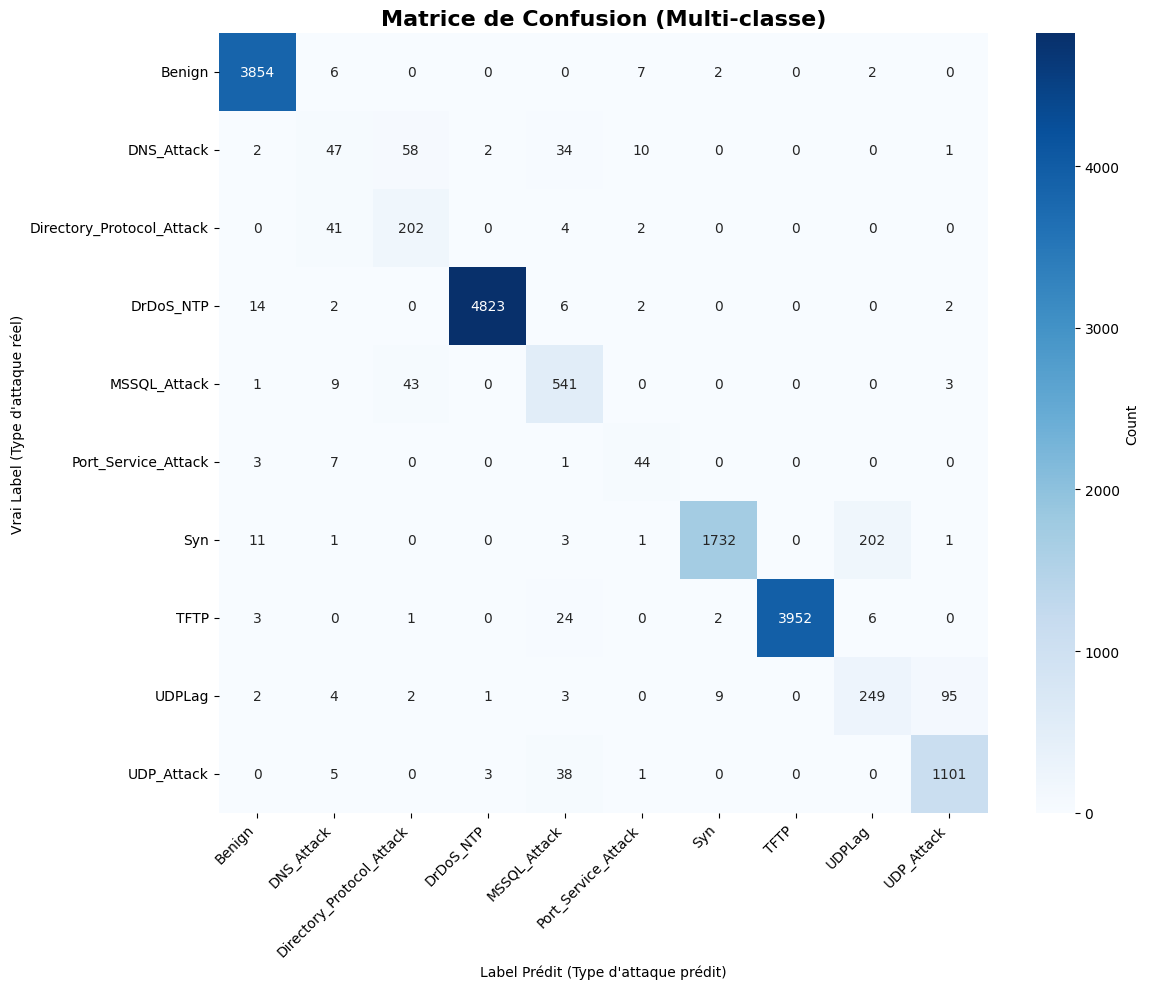


🔍 Analyse des erreurs:
DNS_Attack      → souvent confondu avec Directory_Protocol_Attack (58 fois, 37.7%)
Directory_Protocol_Attack → souvent confondu avec DNS_Attack      (41 fois, 16.5%)
MSSQL_Attack    → souvent confondu avec Directory_Protocol_Attack (43 fois, 7.2%)
Port_Service_Attack → souvent confondu avec DNS_Attack      (7 fois, 12.7%)
Syn             → souvent confondu avec UDPLag          (202 fois, 10.4%)
UDPLag          → souvent confondu avec UDP_Attack      (95 fois, 26.0%)


In [34]:
print("📊 Matrice de confusion MULTI-CLASSE...\n")

# Calculer la matrice de confusion
cm = confusion_matrix(y_test_seq, y_pred)

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Matrice de Confusion (Multi-classe)', fontsize=16, fontweight='bold')
plt.ylabel('Vrai Label (Type d\'attaque réel)')
plt.xlabel('Label Prédit (Type d\'attaque prédit)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyse des erreurs de classification
print("\n🔍 Analyse des erreurs:")
print("=" * 80)

# Pour chaque classe, trouver les confusions principales
for i, true_class in enumerate(label_encoder.classes_):
    errors = cm[i].copy()
    errors[i] = 0  # Ignorer les prédictions correctes

    if errors.sum() > 0:
        top_confusion = np.argmax(errors)
        confusion_count = errors[top_confusion]
        total_true = cm[i].sum()

        if confusion_count > total_true * 0.05:  # Si > 5% d'erreurs
            print(f"{true_class:15s} → souvent confondu avec {label_encoder.classes_[top_confusion]:15s} "
                  f"({confusion_count} fois, {confusion_count/total_true*100:.1f}%)")

16 : Courbe ROC et AUC

📉 Courbes ROC pour chaque classe (One-vs-Rest)...



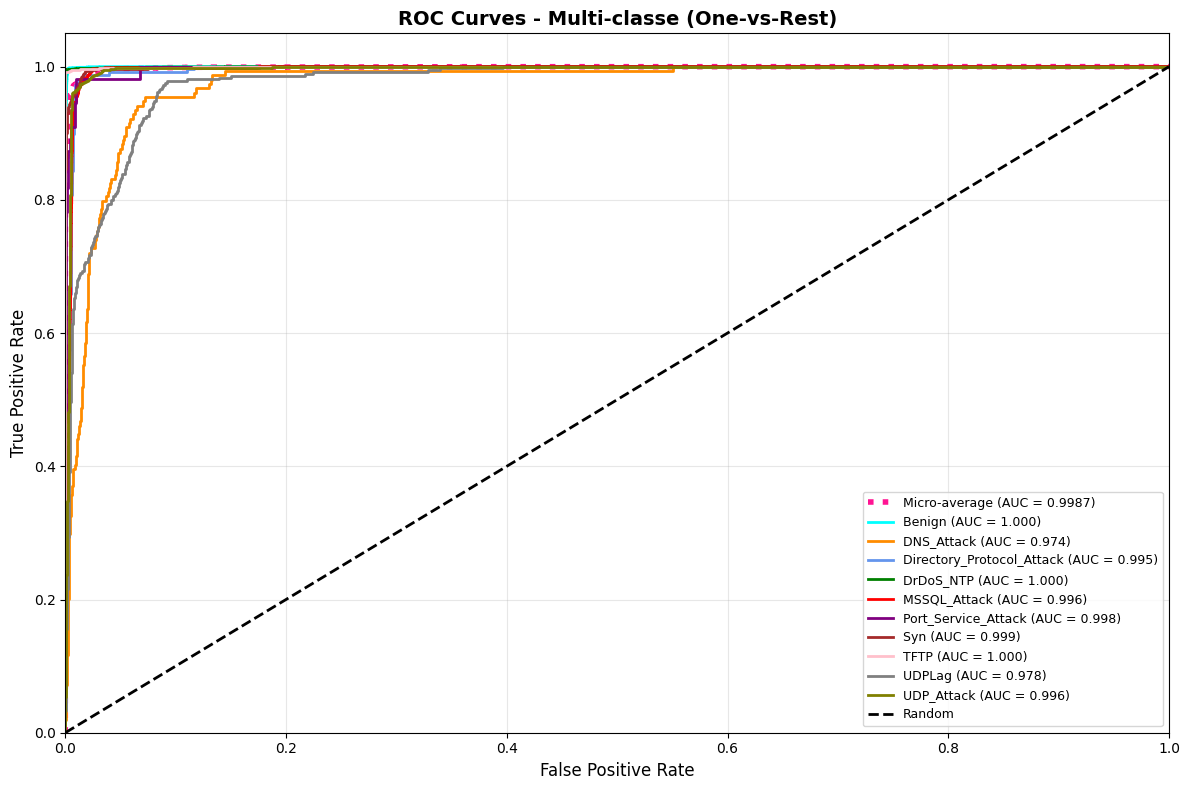


🎯 AUC Score (micro-average): 0.9987

📊 AUC par classe:
   Benign         : 0.9998
   DNS_Attack     : 0.9745
   Directory_Protocol_Attack: 0.9953
   DrDoS_NTP      : 0.9996
   MSSQL_Attack   : 0.9956
   Port_Service_Attack: 0.9976
   Syn            : 0.9987
   TFTP           : 0.9996
   UDPLag         : 0.9777
   UDP_Attack     : 0.9961


In [35]:
print("📉 Courbes ROC pour chaque classe (One-vs-Rest)...\n")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binariser les labels pour ROC multi-classe
y_test_bin = label_binarize(y_test_seq, classes=range(n_classes))

# Calculer ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculer micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Visualisation
plt.figure(figsize=(12, 8))

# Plot micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot pour chaque classe
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-classe (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC Score (micro-average): {roc_auc['micro']:.4f}")
print(f"\n📊 AUC par classe:")
for i in range(n_classes):
    print(f"   {label_encoder.classes_[i]:15s}: {roc_auc[i]:.4f}")

17 : Sauvegarde du modèle final

In [36]:
print("💾 Sauvegarde du modèle et des objets nécessaires...\n")

# Sauvegarder le modèle
model.save('ddos_lstm_multiclass_MERGED_final.keras')
print("✅ Modèle sauvegardé: ddos_lstm_multiclass_MERGED_final.keras")

# Sauvegarder le scaler
joblib.dump(scaler, 'scaler_merged.pkl')
print("✅ Scaler sauvegardé: scaler_merged.pkl")

# Sauvegarder le label encoder
joblib.dump(label_encoder, 'label_encoder_merged.pkl')
print("✅ Label encoder sauvegardé: label_encoder_merged.pkl")

# Sauvegarder les paramètres
params = {
    'sequence_length': SEQUENCE_LENGTH,
    'step': STEP,
    'n_features': n_features,
    'n_classes': n_classes,
    'class_names': list(label_encoder.classes_),
    'feature_names': list(X_train.columns),
    'note': 'Modèle avec classes fusionnées (18→11)'
}
joblib.dump(params, 'model_params_merged.pkl')
print("✅ Paramètres sauvegardés: model_params_merged.pkl")

print("\n📦 Fichiers créés:")
print("   - ddos_lstm_multiclass_MERGED_final.keras (modèle)")
print("   - best_lstm_ddos_multiclass_model.keras (meilleur checkpoint)")
print("   - scaler_merged.pkl (normalisation)")
print("   - label_encoder_merged.pkl (encodage des labels)")
print("   - model_params_merged.pkl (paramètres)")

💾 Sauvegarde du modèle et des objets nécessaires...

✅ Modèle sauvegardé: ddos_lstm_multiclass_MERGED_final.keras
✅ Scaler sauvegardé: scaler_merged.pkl
✅ Label encoder sauvegardé: label_encoder_merged.pkl
✅ Paramètres sauvegardés: model_params_merged.pkl

📦 Fichiers créés:
   - ddos_lstm_multiclass_MERGED_final.keras (modèle)
   - best_lstm_ddos_multiclass_model.keras (meilleur checkpoint)
   - scaler_merged.pkl (normalisation)
   - label_encoder_merged.pkl (encodage des labels)
   - model_params_merged.pkl (paramètres)


18 : Résumé final et conclusions

In [37]:
print("=" * 70)
print("🎉 RÉSUMÉ FINAL - CLASSIFICATION MULTI-CLASSE (AVEC FUSION)")
print("=" * 70)

print(f"\n📊 Dataset:")
print(f"   Train: {len(y_train_final):,} séquences")
print(f"   Validation: {len(y_val):,} séquences")
print(f"   Test: {len(y_test_seq):,} séquences")

print(f"\n🔄 Fusion des classes:")
print(f"   Classes AVANT fusion: 18")
print(f"   Classes APRÈS fusion: {n_classes}")
print(f"   Fusions effectuées:")
print(f"     • UDP + DrDoS_UDP → UDP_Attack")
print(f"     • MSSQL + DrDoS_MSSQL → MSSQL_Attack")
print(f"     • LDAP + DrDoS_LDAP + DrDoS_SNMP → Directory_Protocol_Attack")
print(f"     • NetBIOS + Portmap → Port_Service_Attack")
print(f"     • DrDoS_DNS → DNS_Attack")

print(f"\n🧠 Modèle:")
print(f"   Type: Bidirectional LSTM (Multi-classe)")
print(f"   Séquences: {SEQUENCE_LENGTH} flux consécutifs")
print(f"   Features: {n_features}")
print(f"   Classes: {n_classes}")
print(f"   Types d'attaques: {', '.join(label_encoder.classes_)}")
print(f"   Paramètres: {model.count_params():,}")

print(f"\n🎯 Performances finales (Test Set):")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (weighted): {precision:.4f}")
print(f"   Recall (weighted):    {recall:.4f}")
print(f"   F1-Score (weighted):  {f1:.4f}")
print(f"   AUC (micro-average):  {roc_auc['micro']:.4f}")

print(f"\n⏱️ Informations d'entraînement:")
print(f"   Epochs effectués: {len(history.history['loss'])}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Best val accuracy: {max(history.history['val_accuracy']):.4f}")

print("\n" + "=" * 70)
print("✅ Projet MULTI-CLASSE (avec fusion) terminé avec succès!")
print("=" * 70)

🎉 RÉSUMÉ FINAL - CLASSIFICATION MULTI-CLASSE (AVEC FUSION)

📊 Dataset:
   Train: 55,131 séquences
   Validation: 13,783 séquences
   Test: 17,227 séquences

🔄 Fusion des classes:
   Classes AVANT fusion: 18
   Classes APRÈS fusion: 10
   Fusions effectuées:
     • UDP + DrDoS_UDP → UDP_Attack
     • MSSQL + DrDoS_MSSQL → MSSQL_Attack
     • LDAP + DrDoS_LDAP + DrDoS_SNMP → Directory_Protocol_Attack
     • NetBIOS + Portmap → Port_Service_Attack
     • DrDoS_DNS → DNS_Attack

🧠 Modèle:
   Type: Bidirectional LSTM (Multi-classe)
   Séquences: 10 flux consécutifs
   Features: 77
   Classes: 10
   Types d'attaques: Benign, DNS_Attack, Directory_Protocol_Attack, DrDoS_NTP, MSSQL_Attack, Port_Service_Attack, Syn, TFTP, UDPLag, UDP_Attack
   Paramètres: 299,690

🎯 Performances finales (Test Set):
   Accuracy:  0.9604 (96.04%)
   Precision (weighted): 0.9639
   Recall (weighted):    0.9604
   F1-Score (weighted):  0.9614
   AUC (micro-average):  0.9987

⏱️ Informations d'entraînement:
   Epoch

tests données réelles

In [38]:
print("🔮 TEST RAPIDE - Tous les fichiers")
print("=" * 80)

import glob

# Liste de tous vos fichiers testing
test_files = glob.glob("./ddos_csv_files/*-testing.csv")

print(f"📁 Fichiers trouvés: {len(test_files)}\n")

# Tester chaque fichier
results = []

for test_file in sorted(test_files):
    filename = test_file.split('/')[-1]

    # Charger 10 lignes
    df_test_quick = pd.read_csv(test_file, nrows=10)

    # Séparer features et labels
    y_true = df_test_quick['Label'].copy()
    X_test_quick = df_test_quick.drop('Label', axis=1)

    # Nettoyer
    X_test_quick = X_test_quick.replace([np.inf, -np.inf], np.nan)
    for col in X_test_quick.columns:
        if X_test_quick[col].dtype in ['float64', 'int64']:
            X_test_quick[col].fillna(X_test_quick[col].median(), inplace=True)

    # Normaliser
    X_scaled = scaler.transform(X_test_quick)

    # Créer séquence
    if len(X_scaled) >= SEQUENCE_LENGTH:
        X_seq = X_scaled[:SEQUENCE_LENGTH].reshape(1, SEQUENCE_LENGTH, -1)

        # Prédire
        y_pred_proba = model.predict(X_seq, verbose=0)[0]
        y_pred_class = np.argmax(y_pred_proba)
        y_pred_label = label_encoder.inverse_transform([y_pred_class])[0]
        confidence = y_pred_proba[y_pred_class] * 100

        # Vrai label (fusionné)
        y_true_merged = merge_attack_classes(y_true.iloc[SEQUENCE_LENGTH-1])

        # Statut
        correct = "✅" if y_pred_label == y_true_merged else "❌"

        # Stocker
        results.append({
            'Fichier': filename,
            'Vrai': y_true_merged,
            'Prédit': y_pred_label,
            'Confiance': f"{confidence:.1f}%",
            'Status': correct
        })

        print(f"{correct} {filename:30s} | Vrai: {y_true_merged:25s} | Prédit: {y_pred_label:25s} | Conf: {confidence:5.1f}%")

# Résumé
print("\n" + "=" * 80)
print("📊 RÉSUMÉ")
print("=" * 80)

correct_count = sum(1 for r in results if r['Status'] == '✅')
total_count = len(results)
accuracy = correct_count / total_count * 100 if total_count > 0 else 0

print(f"\nFichiers testés: {total_count}")
print(f"Corrects: {correct_count}")
print(f"Incorrects: {total_count - correct_count}")
print(f"Accuracy: {accuracy:.2f}%")

print("\n✅ TEST TERMINÉ")g

🔮 TEST RAPIDE - Tous les fichiers
📁 Fichiers trouvés: 10

❌ ddos_csv_files\DNS-testing.csv | Vrai: DNS_Attack                | Prédit: Directory_Protocol_Attack | Conf:  73.1%
✅ ddos_csv_files\LDAP-testing.csv | Vrai: Directory_Protocol_Attack | Prédit: Directory_Protocol_Attack | Conf:  72.1%
✅ ddos_csv_files\MSSQL-testing.csv | Vrai: MSSQL_Attack              | Prédit: MSSQL_Attack              | Conf:  54.1%
✅ ddos_csv_files\NTP-testing.csv | Vrai: DrDoS_NTP                 | Prédit: DrDoS_NTP                 | Conf: 100.0%
❌ ddos_csv_files\NetBIOS-testing.csv | Vrai: Port_Service_Attack       | Prédit: DNS_Attack                | Conf:  90.4%
✅ ddos_csv_files\SNMP-testing.csv | Vrai: Directory_Protocol_Attack | Prédit: Directory_Protocol_Attack | Conf:  73.9%
✅ ddos_csv_files\Syn-testing.csv | Vrai: Syn                       | Prédit: Syn                       | Conf:  65.6%
❌ ddos_csv_files\TFTP-testing.csv | Vrai: TFTP                      | Prédit: MSSQL_Attack              | Co